### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from deap import base, creator, tools, algorithms
from itertools import product
import os


### Loading the Dataset

In [2]:
# Load and preprocess the dataset
resampled_data = pd.read_csv('resampled_dataset.csv')
# Dropping the target column
X = resampled_data.drop('Churn', axis=1).values
y = resampled_data['Churn'].values


#### Splitting the dataset

In [3]:
# Split dataset into train (80%) and test (20%) with random state 42 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Defining the Fitness Function

In [4]:
# Define weights for fitness metrics
# Weights for Overall Accuracy (OA), True Churn (TC), and True Non-Churn (TN) metrics
w1, w2, w3 = 0.5, 0.3, 0.2

def compute_fitness(chromosome):
    """
    Compute and return the fitness value of a chromosome for DEAP compatibility.
    
    Fitness is calculated as a weighted combination of three metrics:
    - Overall Accuracy (OA)
    - Accuracy for True Churn cases (TC)
    - Accuracy for True Non-Churn cases (TN)
    
    Args:
        chromosome (list): A binary list where each element represents whether a feature is selected (1) or not (0).

    Returns:
        tuple: A single-element tuple containing the computed fitness value. Returns (-1,) for invalid chromosomes
               with fewer than 4 selected features.
    """
    # Extract indices of features selected by the chromosome (features where the bit is 1)
    selected_features = [i for i, bit in enumerate(chromosome) if bit == 1]
    # Penalize chromosomes with fewer than 4 selected features returning a -ve value for fitness
    if len(selected_features) < 4:
        return (-1,)  # Penalize for fewer than 4 features
    # Create subsets of training and testing datasets with selected features
    X_train_subset = X_train[:, selected_features]
    X_test_subset = X_test[:, selected_features]
    # Initialize and train a Decision Tree Classifier using the selected features
    model = DecisionTreeClassifier()
    model.fit(X_train_subset, y_train)
    # Predict labels on the testing dataset
    y_pred = model.predict(X_test_subset)
    # Compute the confusion matrix to evaluate the model
    cm = confusion_matrix(y_test, y_pred)
    # Calculate evaluation metrics
    OA = (cm[0, 0] + cm[1, 1]) / cm.sum()
    TC = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) != 0 else 0
    TN = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
    # Compute the fitness value as a weighted sum of the metrics
    fitness = w1 * OA + w2 * TC + w3 * TN
    return (fitness,) 



#### Recalculating the Metrics for each objective

In [5]:
def evaluate_test_metrics(chromosome):
    """
    Recalculate OA, TC, and TN metrics for the testing dataset.
    
    This function evaluates the performance of a Decision Tree Classifier on the testing dataset,
    based on features selected by the binary chromosome. The function computes the following metrics:
    - Overall Accuracy (OA)
    - Accuracy for True Churn cases (TC)
    - Accuracy for True Non-Churn cases (TN)
    
    Args:
        chromosome (list): A binary list where each element represents whether a feature is selected (1) or not (0).

    Returns:
        tuple: A tuple containing the recalculated metrics (OA, TC, TN).
    """
    selected_features = [i for i, bit in enumerate(chromosome) if bit == 1]
    X_test_subset = X_test[:, selected_features]

    model = DecisionTreeClassifier()
    model.fit(X_train[:, selected_features], y_train)
    y_pred = model.predict(X_test_subset)
    cm = confusion_matrix(y_test, y_pred)
    
    OA = (cm[0, 0] + cm[1, 1]) / cm.sum()
    TC = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) != 0 else 0
    TN = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
    return OA, TC, TN



### Creating and Initializing a Genetic Algorithm Framework Using DEAP

In [6]:
# Attempt to delete any existing definitions for FitnessMax and Individual in the creator
try:
    del creator.FitnessMax, creator.Individual
except AttributeError:
    pass # If these attributes don't exist, proceed without raising an error

# Create a new fitness class "FitnessMax" to maximize the fitness value
# The weights tuple specifies the optimization direction (1.0 for maximization)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Create a new individual class "Individual" which inherits from a list
# Each individual will have a fitness attribute of type FitnessMax
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the DEAP toolbox to register functions for creating individuals and populations
toolbox = base.Toolbox()

# Register a function to generate random binary attributes (0 or 1) for the chromosome
toolbox.register("attr_bool", np.random.randint, 2)
# Register a function to initialize an individual as a list of binary attributes

# The individual length is equal to the number of features in the dataset (X.shape[1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])

# Register a function to initialize a population as a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



In [7]:
# Define wrapper functions for dynamic registration of crossover methods
def crossover_wrapper(method, indpb=None):
    """
    Wraps crossover methods to allow for flexible parameter passing during registration.
    
    Args:
        method (function): A DEAP crossover function (e.g., cxUniform, cxOnePoint).
        indpb (float, optional): Independent probability for each attribute to be exchanged
                                 (applicable only for Uniform Crossover).
    
    Returns:
        function: A lambda function dynamically configured for the specified crossover method.
    """
    if method.__name__ == "cxUniform":
        return lambda ind1, ind2: method(ind1, ind2, indpb=indpb)
    return lambda ind1, ind2: method(ind1, ind2)

def selection_wrapper(method, tournsize=None):
    """
    Wraps selection methods to allow for flexible parameter passing during registration.
    
    Args:
        method (function): A DEAP selection function (e.g., selTournament, selBest).
        tournsize (int, optional): Tournament size (applicable only for Tournament Selection).
    
    Returns:
        function: A lambda function dynamically configured for the specified selection method.
    """
    if method.__name__ == "selTournament":
        return lambda individuals, k: method(individuals, k, tournsize=tournsize)
    return lambda individuals, k: method(individuals, k)

#### Defining the Parameter - Tuning List

In [7]:
crossover_methods = [tools.cxUniform, tools.cxOnePoint, tools.cxTwoPoint]
crossover_probs = [0.7, 0.9]
mutation_methods = [tools.mutFlipBit]
mutation_probs = [0.01, 1 / 26, 0.1]
selection_methods = [tools.selTournament, tools.selBest]
population_sizes = [100, 200]
generations = [50, 100]


#### Grid Search for Parameter Tuning

In [8]:
# Initialize an empty list to store results for all parameter combinations
results = []

# Perform grid search over all combinations of GA parameters

for cx_method, cx_prob, mut_method, mut_prob, sel_method, pop_size, ngen in product(
        crossover_methods, crossover_probs, mutation_methods, mutation_probs, selection_methods, population_sizes, generations):

    # Record the start time for measuring execution time
    start_time = time.time()
    # Print the current configuration being tested
    print(f"Running: {cx_method.__name__}, cx_prob={cx_prob}, {mut_method.__name__}, "
          f"mut_prob={mut_prob}, {sel_method.__name__}, pop_size={pop_size}, ngen={ngen}")

    # Unregister previously registered operators from the DEAP toolbox (if any)
    toolbox.unregister("mate") if "mate" in toolbox.__dict__ else None
    toolbox.unregister("mutate") if "mutate" in toolbox.__dict__ else None
    toolbox.unregister("select") if "select" in toolbox.__dict__ else None

    # Dynamically register the operators for the current configuration
    toolbox.register("mate", crossover_wrapper(cx_method, indpb=0.5)) # Crossover with specified method and parameters
    toolbox.register("mutate", mut_method, indpb=mut_prob) # Mutation with specified method and probability
    toolbox.register("select", selection_wrapper(sel_method, tournsize=3 if sel_method == tools.selTournament else None)) # Selection with specified method
    toolbox.register("evaluate", compute_fitness) # Fitness evaluation function

    # Initialize the population with the specified size
    population = toolbox.population(n=pop_size)

    # Set up statistics(average, minimum, maximum) tracking for the fitness values during the evolution
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Run the Genetic Algorithm using the eaSimple method
    population, logbook = algorithms.eaSimple(
        population, toolbox, cxpb=cx_prob, mutpb=mut_prob, ngen=ngen, stats=stats, verbose=False
    )

    # Get the best individual
    best_ind = tools.selBest(population, k=1)[0]
    fitness = best_ind.fitness.values[0]

    # Recalculate testing metrics for the best individual
    OA_test, TC_test, TN_test = evaluate_test_metrics(best_ind)

    # Record the end time for this configuration
    end_time = time.time()

    # Append the results for this configuration to the results list
    results.append({
        'Crossover Method': cx_method.__name__,
        'Crossover Prob': cx_prob,
        'Mutation Method': mut_method.__name__,
        'Mutation Prob': mut_prob,
        'Selection Method': sel_method.__name__,
        'Population Size': pop_size,
        'Generations': ngen,
        'Best Fitness': fitness,
        'Testing OA': OA_test,
        'Testing TC': TC_test,
        'Testing TN': TN_test,
        'Selected Features': [i for i, bit in enumerate(best_ind) if bit == 1],
        'Time Taken (s)': round(end_time - start_time, 2),
        'Logbook': logbook  # Store logbook for plotting
    })

# Save results to csv
results_df = pd.DataFrame(results)
results_df.to_csv('grid_search_results_with_test_metrics.csv', index=False)

# Create a folder to save the best 5 plots
output_folder = "best_plots"
os.makedirs(output_folder, exist_ok=True)

# Sort results by 'Best Fitness' and select the top 5
top_results = sorted(results, key=lambda x: x['Best Fitness'], reverse=True)[:5]

# Generate and save plots for the top 5 configurations
for i, result in enumerate(top_results):
    logbook = result['Logbook']
    gen = logbook.select("gen")
    avg_fitness = logbook.select("avg")
    min_fitness = logbook.select("min")
    max_fitness = logbook.select("max")
    
    # Plot the fitness evolution
    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg_fitness, label="Average Fitness")
    plt.plot(gen, min_fitness, label="Minimum Fitness")
    plt.plot(gen, max_fitness, label="Maximum Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"Fitness Evolution: {result['Crossover Method']}, cx={result['Crossover Prob']}, "
              f"{result['Mutation Method']}, mut={result['Mutation Prob']}, "
              f"{result['Selection Method']}, pop_size={result['Population Size']}, ngen={result['Generations']}")
    plt.legend()
    plt.grid()

    # Save the plot
    plot_filename = f"plot_{i + 1}_{result['Crossover Method']}_cx{result['Crossover Prob']}_mut{result['Mutation Prob']}_sel{result['Selection Method']}.png"
    plt.savefig(os.path.join(output_folder, plot_filename))
    plt.close()

    # Print result details of top 5
    print(f"--- Top {i + 1} Configuration ---")
    print(f"Crossover Method: {result['Crossover Method']}, Crossover Prob: {result['Crossover Prob']}")
    print(f"Mutation Method: {result['Mutation Method']}, Mutation Prob: {result['Mutation Prob']}")
    print(f"Selection Method: {result['Selection Method']}")
    print(f"Population Size: {result['Population Size']}, Generations: {result['Generations']}")
    print(f"Best Fitness: {result['Best Fitness']}")
    print(f"Testing OA: {result['Testing OA']}, Testing TC: {result['Testing TC']}, Testing TN: {result['Testing TN']}")
    print(f"Selected Features: {result['Selected Features']}")
    print()

print(f"Top 5 plots have been saved in the folder: {output_folder}")

Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.01, selTournament, pop_size=100, ngen=50
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.01, selTournament, pop_size=100, ngen=100
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.01, selTournament, pop_size=200, ngen=50
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.01, selTournament, pop_size=200, ngen=100
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.01, selBest, pop_size=100, ngen=50
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.01, selBest, pop_size=100, ngen=100
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.01, selBest, pop_size=200, ngen=50
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.01, selBest, pop_size=200, ngen=100
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.038461538461538464, selTournament, pop_size=100, ngen=50
Running: cxUniform, cx_prob=0.7, mutFlipBit, mut_prob=0.038461538461538464, selTournament, pop_size=100, ngen=100
Running: cxUnifor

Output of Top 5
--- Top 1 Configuration ---
Crossover Method: cxOnePoint, Crossover Prob: 0.7
Mutation Method: mutFlipBit, Mutation Prob: 0.1
Selection Method: selTournament
Population Size: 200, Generations: 50
Best Fitness: 0.8442389609014946
Testing OA: 0.8301064859632139, Testing TC: 0.8377065111758989, Testing TN: 0.8225650916104147
Selected Features: [1, 4, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

### Best Parameters Selected

In [8]:
# Set parameter based on the best config
crossover_method = tools.cxOnePoint
crossover_prob = 0.7
mutation_method = tools.mutFlipBit
mutation_prob = 0.1
selection_method = tools.selTournament
population_size = 200
num_generations = 50

### Running for different 5 runs with different populations using the best config


Running GA - Iteration 1
Iteration 1 Best Individual Fitness: 0.8381322994702731
Selected Features: [2, 5, 7, 10, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Overall Accuracy (OA): 0.8379
True Churn Rate (TC): 0.8406
True Non-Churn Rate (TN): 0.8351
Run Time: 233.96 seconds

Running GA - Iteration 2
Iteration 2 Best Individual Fitness: 0.8375987407280099
Selected Features: [7, 8, 10, 13, 16, 18, 20, 21, 22, 23, 24, 25]
Overall Accuracy (OA): 0.8374
True Churn Rate (TC): 0.8397
True Non-Churn Rate (TN): 0.8351
Run Time: 146.08 seconds

Running GA - Iteration 3
Iteration 3 Best Individual Fitness: 0.8381322994702731
Selected Features: [2, 5, 7, 10, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Overall Accuracy (OA): 0.8379
True Churn Rate (TC): 0.8406
True Non-Churn Rate (TN): 0.8351
Run Time: 78.15 seconds

Running GA - Iteration 4
Iteration 4 Best Individual Fitness: 0.8381322994702731
Selected Features: [2, 5, 7, 10, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Overall Accuracy (OA): 0.

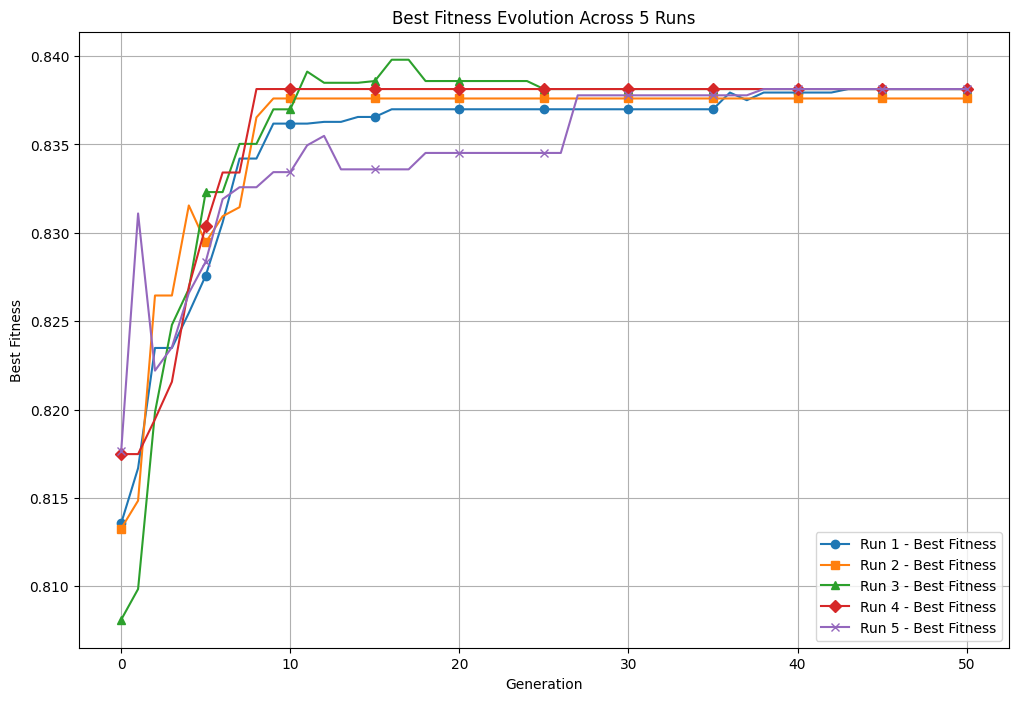

In [38]:
try:
    del creator.FitnessMax, creator.Individual
except AttributeError:
    pass

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Wrapper functions for dynamic registration
def crossover_wrapper(method, indpb=None):
    if method.__name__ == "cxUniform":
        return lambda ind1, ind2: method(ind1, ind2, indpb=indpb)
    return lambda ind1, ind2: method(ind1, ind2)

def selection_wrapper(method, tournsize=None):
    if method.__name__ == "selTournament":
        return lambda individuals, k: method(individuals, k, tournsize=tournsize)
    return lambda individuals, k: method(individuals, k)

# Set parameters based on best config
crossover_method = tools.cxOnePoint
crossover_prob = 0.7
mutation_method = tools.mutFlipBit
mutation_prob = 0.1
selection_method = tools.selTournament
population_size = 200
num_generations = 50

# Register required functions and operators
toolbox.unregister("mate") if "mate" in toolbox.__dict__ else None
toolbox.unregister("mutate") if "mutate" in toolbox.__dict__ else None
toolbox.unregister("select") if "select" in toolbox.__dict__ else None

toolbox.register("mate", crossover_wrapper(crossover_method, indpb=0.5))
toolbox.register("mutate", mutation_method, indpb=mutation_prob)
toolbox.register("select", selection_wrapper(selection_method, tournsize=3))
toolbox.register("evaluate", compute_fitness)

plt.figure(figsize=(12, 8))
markers = ['o', 's', '^', 'D', 'x']  

# List to store the best fitness of each run
all_run_best_fitnesses = []

for run in range(1, 6):
    print(f"\nRunning GA - Iteration {run}")
    population = toolbox.population(n=population_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)  # Only track the maximum fitness

    start_time = time.time()
    population, logbook = algorithms.eaSimple(
        population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob,
        ngen=num_generations, stats=stats, verbose=False
    )
    end_time = time.time()

    # Extract data for plotting
    gen = logbook.select("gen")
    max_fitness = logbook.select("max")

    # Plot results for this run with markers
    plt.plot(gen, max_fitness, label=f"Run {run} - Best Fitness", marker=markers[run - 1], markevery=5)

    # Extract the best individual
    best_individual = tools.selBest(population, k=1)[0]
    selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

    # Compute OA, TC, TN for the best individual
    X_train_subset = X_train[:, selected_features]
    X_test_subset = X_test[:, selected_features]

    model = DecisionTreeClassifier()
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    cm = confusion_matrix(y_test, y_pred)

    OA = (cm[0, 0] + cm[1, 1]) / cm.sum()
    TC = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) != 0 else 0
    TN = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0

    # Print summary for the run
    run_best_fitness = best_individual.fitness.values[0]
    all_run_best_fitnesses.append(run_best_fitness)

    print(f"Iteration {run} Best Individual Fitness: {run_best_fitness}")
    print(f"Selected Features: {selected_features}")
    print(f"Overall Accuracy (OA): {OA:.4f}")
    print(f"True Churn Rate (TC): {TC:.4f}")
    print(f"True Non-Churn Rate (TN): {TN:.4f}")
    print(f"Run Time: {end_time - start_time:.2f} seconds")

# After all runs calculate and print the MBF
MBF = np.mean(all_run_best_fitnesses)
print("\nSummary Across All 5 Runs:")
print(f"Mean Best Fitness (MBF): {MBF:.4f}")

# Plot
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Best Fitness Evolution Across 5 Runs")
plt.legend()
plt.grid()
plt.show()


### One Run


Single Iteration Summary:
Best Individual Fitness: 0.8381322994702731
Selected Features: [2, 5, 7, 10, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Overall Accuracy (OA): 0.8379
True Churn Rate (TC): 0.8406
True Non-Churn Rate (TN): 0.8351
Run Time: 106.18 seconds


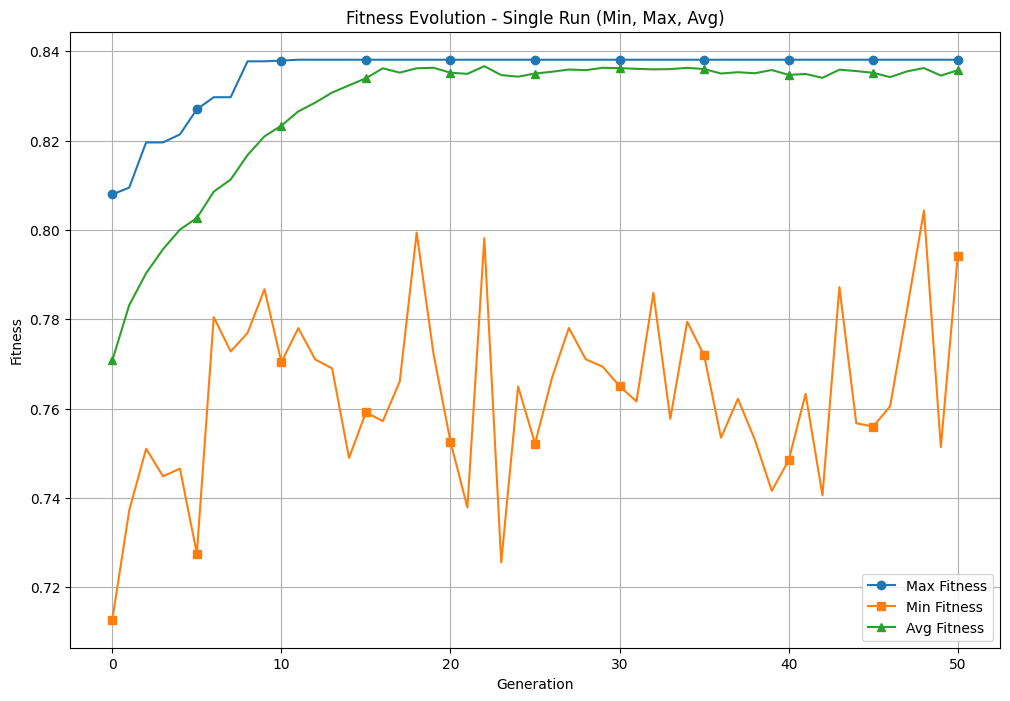

In [9]:
toolbox.register("mate", crossover_wrapper(crossover_method, indpb=0.5))
toolbox.register("mutate", mutation_method, indpb=mutation_prob)
toolbox.register("select", selection_wrapper(selection_method, tournsize=3))
toolbox.register("evaluate", compute_fitness)

# Initialize population and statistics
population = toolbox.population(n=population_size)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)  
stats.register("max", np.max)  
stats.register("avg", np.mean)  

# Run the GA and record time
start_time = time.time()
population, logbook = algorithms.eaSimple(
    population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob,
    ngen=num_generations, stats=stats, verbose=False
)
end_time = time.time()

# Extract data for plotting
gen = logbook.select("gen")
min_fitness = logbook.select("min")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(gen, max_fitness, label="Max Fitness", marker='o', markevery=5)
plt.plot(gen, min_fitness, label="Min Fitness", marker='s', markevery=5)
plt.plot(gen, avg_fitness, label="Avg Fitness", marker='^', markevery=5)

# Evaluate the best individual
best_individual = tools.selBest(population, k=1)[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

# Compute metrics for the best individual
OA, TC, TN = evaluate_test_metrics(best_individual)

# Print summary for the run
print(f"\nSingle Iteration Summary:")
print(f"Best Individual Fitness: {best_individual.fitness.values[0]}")
print(f"Selected Features: {selected_features}")
print(f"Overall Accuracy (OA): {OA:.4f}")
print(f"True Churn Rate (TC): {TC:.4f}")
print(f"True Non-Churn Rate (TN): {TN:.4f}")
print(f"Run Time: {end_time - start_time:.2f} seconds")

# Plot labels and legend
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Evolution - Single Run (Min, Max, Avg)")
plt.legend()
plt.grid()
plt.show()
